<a href="https://colab.research.google.com/github/parthkotwal/braai-cnn/blob/main/braai_cnn_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --quiet fastavro astropy aplpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.9/378.9 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.7/738.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 534.8/534.8 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.2/195.2 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.4/205.4 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 

In [8]:
import tarfile
import os

tar_file = "drive/MyDrive/braai_cnn/ztf_public_20250302.tar.gz"
extract_dir = "drive/MyDrive/braai_cnn/ztf_avro_data"

try:
    with tarfile.open(tar_file, "r:gz") as tar:
        tar.extractall(path=extract_dir)
    print(f"Extracted to: {extract_dir}")
except tarfile.ReadError as e:
    print("Extraction failed:", e)


Extracted to: drive/MyDrive/braai_cnn/ztf_avro_data


In [9]:
def find_files(root_dir):
  for dir_name, subdir_list, file_list in os.walk(root_dir, followlinks=True):
    for fname in file_list:
      if fname.endswith('.avro'):
        yield f"{dir_name}/{fname}"

files_gen = list(find_files(extract_dir))
print(f'{extract_dir} has {len(files_gen)} avro files')

drive/MyDrive/braai_cnn/ztf_avro_data has 38368 avro files


In [10]:
import fastavro

with open(files_gen[0], 'rb') as f:
    reader = fastavro.reader(f)
    packet = next(reader)
    print(packet.keys())

dict_keys(['schemavsn', 'publisher', 'objectId', 'candid', 'candidate', 'prv_candidates', 'fp_hists', 'cutoutScience', 'cutoutTemplate', 'cutoutDifference'])


In [17]:
import gzip
import io
from astropy.io import fits

files = files_gen[:400]
shapes = {}
for fn in files:
    with open(fn,'rb') as f:
        pkt = next(fastavro.reader(f))
    stamp = pkt['cutoutDifference']['stampData']
    with gzip.open(io.BytesIO(stamp),'rb') as g:
        data = fits.open(io.BytesIO(g.read()))[0].data
    shapes[data.shape] = shapes.get(data.shape,0) + 1

print("Stamp shape distribution:")
for shape, cnt in sorted(shapes.items()):
    print(f"  {shape}: {cnt}")

Stamp shape distribution:
  (42, 63): 1
  (46, 63): 1
  (53, 63): 2
  (62, 63): 1
  (63, 44): 1
  (63, 45): 3
  (63, 46): 2
  (63, 49): 1
  (63, 51): 1
  (63, 53): 2
  (63, 54): 1
  (63, 57): 1
  (63, 59): 1
  (63, 62): 1
  (63, 63): 381


/usr/local/lib/python3.11/dist-packages/astropy/io/fits/hdu/hdulist.py:1231: VerifyWarning: Found a SIMPLE card but its format doesn't respect the FITS Standard
  warnings.warn(


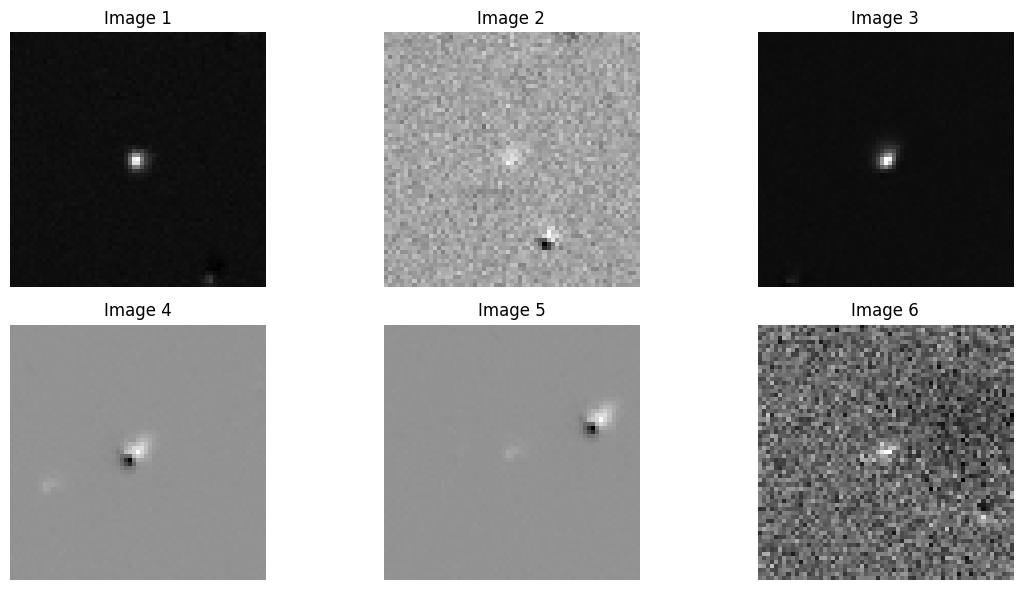

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def get_difference_image(avro_path):
    with open(avro_path, 'rb') as f:
        reader = fastavro.reader(f)
        for packet in reader:
          stamp = packet['cutoutDifference']['stampData']
          with gzip.open(io.BytesIO(stamp), 'rb') as gf:
              with fits.open(io.BytesIO(gf.read())) as hdul:
                  data = hdul[0].data
                  return data.astype(np.float32)

plt.figure(figsize=(12, 6))
count = 0
for i, path in enumerate(files_gen):
    img = get_difference_image(path)
    if img is not None and img.shape == (63, 63):
        plt.subplot(2, 3, count + 1)
        plt.imshow(img, cmap='gray', origin='lower')
        plt.title(f"Image {i}")
        plt.axis('off')
        count += 1
        if count == 6:
            break

plt.tight_layout()
plt.show()

In [18]:
# Extract image from Avro file stamp data
def extract_image(stamp_data):
  with gzip.open(io.BytesIO(stamp_data), 'rb') as f:
    with fits.open(io.BytesIO(f.read())) as hdul:
      data = hdul[0].data
      return data.astype(np.float32)

In [44]:
# Normalize image from 0 to 1
def normalize_image(img):
  img = np.nan_to_num(img, nan=0.0)
  min_val = np.min(img)
  max_val = np.max(img)
  normalized_image = (img - min_val) / float(max_val - min_val)
  return normalized_image

In [20]:
# Pad img shapes to 63, 63
def pad_image(img):
  h, w = img.shape
  pad_h = 63 - h
  pad_w = 63 - w
  pad_top = pad_h // 2
  pad_bottom = pad_h - pad_top
  pad_left = pad_w // 2
  pad_right = pad_w - pad_left
  return np.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right)), 'constant', constant_values=0)

In [51]:
with open(files_gen[0], 'rb') as f:
    reader = fastavro.reader(f)
    packet = next(reader)

    img = extract_image(packet['cutoutDifference']['stampData'])
    print(f"Raw: \n{img}")
    print(f"Raw img shape: {img.shape}")


    norm_img = normalize_image(img)
    paddded_img = pad_image(norm_img)
    print(f"Padded: \n{paddded_img}")
    print(f"Padded img shape: {paddded_img.shape}")

Raw: 
[[  5.563534    -7.3646345    7.0627956  ...   7.6137476   -3.2856426
   -1.272709  ]
 [ -1.3615384   -1.6229812    6.5341887  ... -11.552932    -1.262141
    1.130061  ]
 [ -4.7202168   -0.34604773   2.1768353  ...  -1.0252413    5.5219665
   -7.620818  ]
 ...
 [  6.886244    -8.355415    -6.6425233  ...  -9.032979    -2.2566617
  -13.624665  ]
 [-14.793417   -18.072886   -13.873298   ... -13.994884   -13.109203
  -17.303469  ]
 [-38.16324    -52.183323   -42.60216    ... -46.258186   -43.597652
  -40.308205  ]]
Raw img shape: (46, 63)
Padded: 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Padded img shape: (63, 63)


/usr/local/lib/python3.11/dist-packages/astropy/io/fits/hdu/hdulist.py:1231: VerifyWarning: Found a SIMPLE card but its format doesn't respect the FITS Standard
  warnings.warn(


In [57]:
images = []
labels = []

for i, avro_file in enumerate(files_gen):
  try:
    with open(avro_file, 'rb') as f:
      reader = fastavro.reader(f)
      for packet in reader:
        img = extract_image(packet['cutoutDifference']['stampData'])
        if img is None:
          continue

        norm_img = normalize_image(img)
        r, c = norm_img.shape
        if r != 63 or c != 63:
          padded_img = pad_image(norm_img)
        else:
          padded_img = norm_img

        rb_score = packet['candidate'].get('rb',0)
        if rb_score > 0.7:
          label = 1
        else:
          label = 0

        images.append(padded_img)
        labels.append(label)
        break  # One alert per .avro file

  except Exception as e:
        print(f"Skipping {avro_file} due to error: {e}")


/usr/local/lib/python3.11/dist-packages/astropy/io/fits/hdu/hdulist.py:1231: VerifyWarning: Found a SIMPLE card but its format doesn't respect the FITS Standard
  warnings.warn(


In [58]:
images = np.stack(images)
labels = np.array(labels)
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Images shape: (38368, 63, 63)
Labels shape: (38368,)


In [60]:
save_path = "drive/MyDrive/braai_cnn/ztf_diff_dataset.npz"
np.savez(save_path, images=images, labels=labels)
print(f"Saved dataset to {save_path}")

Saved dataset to drive/MyDrive/braai_cnn/ztf_diff_dataset.npz
